In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [23]:
# Set seed for reproducibility
np.random.seed(42)

# Load and preprocess data
train_dir = "cropped_roi_images/train"
val_dir = "cropped_roi_images/val"
test_dir = "cropped_roi_images/test"
img_size = (224, 224)  # Input image size for VGG16

In [24]:
# Data augmentation and normalization for training and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=32,
                                                    class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=img_size,
                                                batch_size=32,
                                                class_mode='binary')

# Test the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=img_size,
                                                  batch_size=1,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 8621 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.


In [25]:
# Load pre-trained VGG16 model without top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add custom classification layers on top of pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [26]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))


Epoch 1/30
270/270 [==============================] - 270s 994ms/step - loss: 0.6544 - accuracy: 0.6062 - val_loss: 0.6322 - val_accuracy: 0.6252
Epoch 2/30
270/270 [==============================] - 246s 912ms/step - loss: 0.6266 - accuracy: 0.6422 - val_loss: 0.6188 - val_accuracy: 0.6438
Epoch 3/30
270/270 [==============================] - 242s 899ms/step - loss: 0.6151 - accuracy: 0.6578 - val_loss: 0.6051 - val_accuracy: 0.6675
Epoch 4/30
270/270 [==============================] - 792s 3s/step - loss: 0.6064 - accuracy: 0.6703 - val_loss: 0.5976 - val_accuracy: 0.6722
Epoch 5/30
270/270 [==============================] - 496s 2s/step - loss: 0.5990 - accuracy: 0.6766 - val_loss: 0.5919 - val_accuracy: 0.6823
Epoch 6/30
270/270 [==============================] - 495s 2s/step - loss: 0.5929 - accuracy: 0.6802 - val_loss: 0.5840 - val_accuracy: 0.6925
Epoch 7/30
270/270 [==============================] - 495s 2s/step - loss: 0.5908 - accuracy: 0.6860 - val_loss: 0.5798 - val_accurac

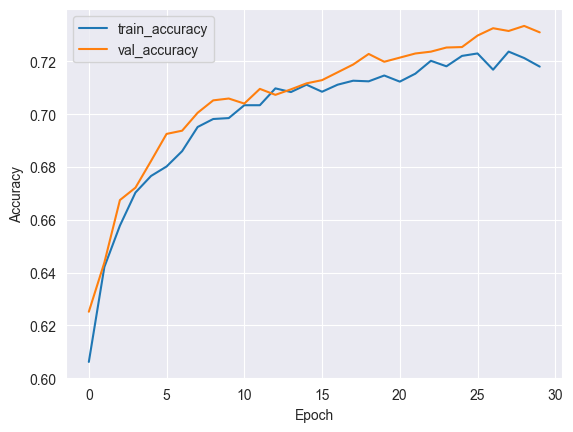

In [27]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions).flatten()

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

2874/2874 [==============================] - 227s 79ms/step


In [29]:
# Evaluate model performance
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\nAccuracy Score:", accuracy_score(true_classes, predicted_classes))

Confusion Matrix:
[[1611  143]
 [ 606  514]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1754
           1       0.78      0.46      0.58      1120

    accuracy                           0.74      2874
   macro avg       0.75      0.69      0.69      2874
weighted avg       0.75      0.74      0.72      2874


Accuracy Score: 0.7393876130828114


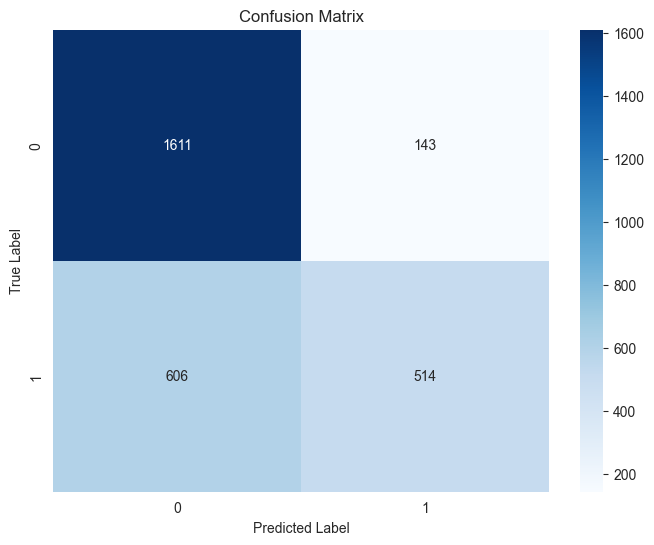

In [30]:
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for SVM classifier
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Feature extraction using pre-trained model
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)

train_features = feature_extractor.predict(train_generator)
val_features = feature_extractor.predict(val_generator)

ValueError: No such layer: global_average_pooling2d. Existing layers are: ['input_3', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'global_average_pooling2d_2', 'dense_2'].

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, train_generator.classes)

In [ ]:
# Evaluate SVM classifier
svm_train_acc = svm_classifier.score(train_features, train_generator.classes)
svm_val_acc = svm_classifier.score(val_features, val_generator.classes)

print("SVM Training Accuracy:", svm_train_acc)
print("SVM Validation Accuracy:", svm_val_acc)

In [ ]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_generator.classes)

In [ ]:
# Evaluate Random Forest classifier
rf_train_acc = rf_classifier.score(train_features, train_generator.classes)
rf_val_acc = rf_classifier.score(val_features, val_generator.classes)

print("Random Forest Training Accuracy:", rf_train_acc)
print("Random Forest Validation Accuracy:", rf_val_acc)

In [ ]:
# Confusion matrix for SVM classifier using test data
svm_test_features = feature_extractor.predict(test_generator)
svm_test_predictions = svm_classifier.predict(svm_test_features)
svm_test_conf_matrix = confusion_matrix(test_generator.classes, svm_test_predictions)

# Plot confusion matrix for SVM classifier
plt.figure(figsize=(8, 6))
sns.heatmap(svm_test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM Classifier (Test Data)')
plt.show()